Epoch 1/20, Loss: 546.316434
Epoch 2/20, Loss: 544.569354
Epoch 3/20, Loss: 544.096938
Epoch 4/20, Loss: 543.882096
Epoch 5/20, Loss: 543.758509
Epoch 6/20, Loss: 543.677566
Epoch 7/20, Loss: 543.621058
Epoch 8/20, Loss: 543.580545
Epoch 9/20, Loss: 543.550693
Epoch 10/20, Loss: 543.527584
Epoch 11/20, Loss: 543.509876
Epoch 12/20, Loss: 543.495958
Epoch 13/20, Loss: 543.485282
Epoch 14/20, Loss: 543.476346
Epoch 15/20, Loss: 543.469146
Epoch 16/20, Loss: 543.463319
Epoch 17/20, Loss: 543.457971
Epoch 18/20, Loss: 543.453282
Epoch 19/20, Loss: 543.449881
Epoch 20/20, Loss: 543.446685
Anomaly Threshold (95th percentile): 0.000124
False Positive Rate (normal images flagged as anomalous): 0.0550
True Positive Rate (anomalous images flagged as anomalous): 1.0000


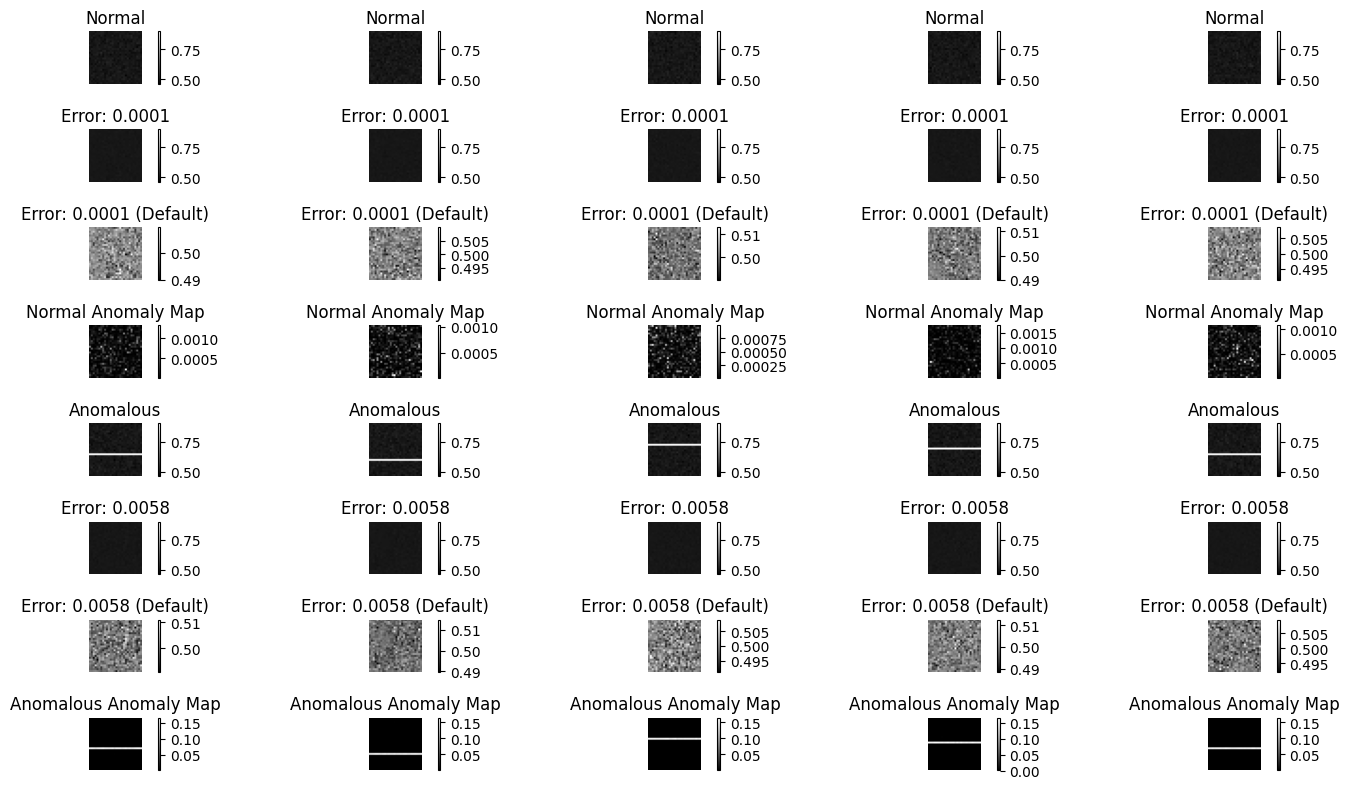

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=16, img_height=28, img_width=28):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.img_height = img_height
        self.img_width = img_width

        # Calculate feature map size after convolutions
        def calc_feature_size(h, w):
            # Two conv layers with stride=2, padding=1, kernel_size=4
            h = (h - 4 + 2 * 1) // 2 + 1  # First conv
            w = (w - 4 + 2 * 1) // 2 + 1
            h = (h - 4 + 2 * 1) // 2 + 1  # Second conv
            w = (w - 4 + 2 * 1) // 2 + 1
            return h, w

        feat_h, feat_w = calc_feature_size(img_height, img_width)
        self.feature_dim = 64 * feat_h * feat_w

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, feat_h, feat_w)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

# Generate synthetic WGN images (normal data)
def generate_wgn_images(num_samples, height=28, width=28, channels=1):
    images = np.random.normal(loc=0.5, scale=0.05, size=(num_samples, channels, height, width))
    images = np.clip(images, 0, 1)
    return torch.tensor(images, dtype=torch.float32)

# Generate anomalous images (WGN + bright straight line)
def generate_anomalous_images(num_samples, height=28, width=28, channels=1):
    images = np.random.normal(loc=0.5, scale=0.05, size=(num_samples, channels, height, width))
    for i in range(num_samples):
        # Add a horizontal straight line with high brightness (e.g., value 0.9)
        line_position = np.random.randint(height // 4, 3 * height // 4)  # Random row for variety
        for c in range(channels):
            images[i, c, line_position, :] = 0.9  # Set entire row to high brightness
    images = np.clip(images, 0, 1)
    return torch.tensor(images, dtype=torch.float32)

# Training function
def train_vae(model, data_loader, epochs=20, learning_rate=1e-4, beta=1.0):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader.dataset):.6f}")

# Anomaly detection
def detect_anomalies(model, data_loader, threshold):
    model.eval()
    anomalies = []
    recon_errors = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            recon_error = nn.functional.mse_loss(recon, data, reduction='none').mean(dim=(1,2,3))
            recon_errors.extend(recon_error.cpu().numpy())
            anomalies.extend((recon_error > threshold).cpu().numpy())
    return np.array(anomalies), np.array(recon_errors)

# Generate anomaly map
def generate_anomaly_map(original, reconstructed):
    anomaly_map = (original - reconstructed).pow(2)
    anomaly_map = anomaly_map.mean(dim=1, keepdim=True)
    # anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)
    return anomaly_map

# Visualize anomaly maps
def visualize_anomaly_maps(model, normal_data, anomalous_data, num_samples=5):
    model.eval()
    with torch.no_grad():
        # Process normal samples
        normal_samples = normal_data[:num_samples].to(device)
        normal_recon, _, _ = model(normal_samples)
        normal_anomaly_maps = generate_anomaly_map(normal_samples, normal_recon)
        normal_recon_errors = nn.functional.mse_loss(normal_recon, normal_samples, reduction='none').mean(dim=(1,2,3)).cpu().numpy()

        # Process anomalous samples
        anomalous_samples = anomalous_data[:num_samples].to(device)
        anomalous_recon, _, _ = model(anomalous_samples)
        anomalous_anomaly_maps = generate_anomaly_map(anomalous_samples, anomalous_recon)
        anomalous_recon_errors = nn.functional.mse_loss(anomalous_recon, anomalous_samples, reduction='none').mean(dim=(1,2,3)).cpu().numpy()

        plt.figure(figsize=(15, 8))

        # Find global min/max for normal and reconstructed images
        vmin = min(normal_samples.min().item(), normal_recon.min().item(), 
                  anomalous_samples.min().item(), anomalous_recon.min().item())
        vmax = max(normal_samples.max().item(), normal_recon.max().item(),
                  anomalous_samples.max().item(), anomalous_recon.max().item())

        # Plot normal samples
        for i in range(num_samples):
            # Original
            plt.subplot(8, num_samples, i + 1)
            plt.imshow(normal_samples[i].cpu().squeeze(), cmap='gray', vmin=vmin, vmax=vmax)
            plt.colorbar()
            plt.title("Normal")
            plt.axis('off')
            # Reconstructed (gray)
            plt.subplot(8, num_samples, i + 1 + num_samples)
            plt.imshow(normal_recon[i].cpu().squeeze(), cmap='gray', vmin=vmin, vmax=vmax)
            plt.colorbar()
            plt.title(f"Error: {normal_recon_errors[i]:.4f}")
            plt.axis('off')
            # Reconstructed (default)
            plt.subplot(8, num_samples, i + 1 + 2 * num_samples)
            plt.imshow(normal_recon[i].cpu().squeeze(), cmap='gray')
            plt.colorbar()
            plt.title(f"Error: {normal_recon_errors[i]:.4f} (Default)")
            plt.axis('off')
            # Anomaly Map
            plt.subplot(8, num_samples, i + 1 + 3 * num_samples)
            plt.imshow(normal_anomaly_maps[i].cpu().squeeze(), cmap='gray')
            plt.colorbar()
            plt.title("Normal Anomaly Map")
            plt.axis('off')

        # Plot anomalous samples
        for i in range(num_samples):
            # Original
            plt.subplot(8, num_samples, i + 1 + 4 * num_samples)
            plt.imshow(anomalous_samples[i].cpu().squeeze(), cmap='gray', vmin=vmin, vmax=vmax)
            plt.colorbar()
            plt.title("Anomalous")
            plt.axis('off')
            # Reconstructed (gray)
            plt.subplot(8, num_samples, i + 1 + 5 * num_samples)
            plt.imshow(anomalous_recon[i].cpu().squeeze(), cmap='gray', vmin=vmin, vmax=vmax)
            plt.colorbar()
            plt.title(f"Error: {anomalous_recon_errors[i]:.4f}")
            plt.axis('off')
            # Reconstructed (default)
            plt.subplot(8, num_samples, i + 1 + 6 * num_samples)
            plt.imshow(anomalous_recon[i].cpu().squeeze(), cmap='gray')
            plt.colorbar()
            plt.title(f"Error: {anomalous_recon_errors[i]:.4f} (Default)")
            plt.axis('off')
            # Anomaly Map
            plt.subplot(8, num_samples, i + 1 + 7 * num_samples)
            plt.imshow(anomalous_anomaly_maps[i].cpu().squeeze(), cmap='gray')
            plt.colorbar()
            plt.title("Anomalous Anomaly Map")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 128
    latent_dim = 16
    epochs = 20
    beta = 1.0

    # Generate training data (WGN images)
    num_train_samples = 10000
    train_data = generate_wgn_images(num_train_samples)
    train_dataset = TensorDataset(train_data, torch.zeros(num_train_samples))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize and train VAE
    vae = VAE(input_channels=1, latent_dim=latent_dim).to(device)
    train_vae(vae, train_loader, epochs=epochs, learning_rate=1e-4, beta=beta)

    # Determine anomaly threshold
    vae.eval()
    recon_errors = []
    with torch.no_grad():
        for data, _ in train_loader:
            data = data.to(device)
            recon, _, _ = vae(data)
            error = nn.functional.mse_loss(recon, data, reduction='none').mean(dim=(1,2,3))
            recon_errors.extend(error.cpu().numpy())
    threshold = np.percentile(recon_errors, 95)
    print(f"Anomaly Threshold (95th percentile): {threshold:.6f}")

    # Generate test data (both normal and anomalous)
    num_test_samples = 1000
    normal_test_data = generate_wgn_images(num_test_samples)
    anomalous_test_data = generate_anomalous_images(num_test_samples)
    
    # Create test datasets
    normal_test_dataset = TensorDataset(normal_test_data, torch.zeros(num_test_samples))
    anomalous_test_dataset = TensorDataset(anomalous_test_data, torch.ones(num_test_samples))
    
    normal_test_loader = DataLoader(normal_test_dataset, batch_size=batch_size, shuffle=False)
    anomalous_test_loader = DataLoader(anomalous_test_dataset, batch_size=batch_size, shuffle=False)

    # Detect anomalies on both normal and anomalous data
    normal_anomalies, normal_recon_errors = detect_anomalies(vae, normal_test_loader, threshold)
    anomalous_anomalies, anomalous_recon_errors = detect_anomalies(vae, anomalous_test_loader, threshold)
    
    # Calculate metrics
    false_positive_rate = normal_anomalies.mean()
    true_positive_rate = anomalous_anomalies.mean()
    
    print(f"False Positive Rate (normal images flagged as anomalous): {false_positive_rate:.4f}")
    print(f"True Positive Rate (anomalous images flagged as anomalous): {true_positive_rate:.4f}")

    # Visualize anomaly maps for both normal and anomalous images
    visualize_anomaly_maps(vae, normal_test_data, anomalous_test_data, num_samples=5)